# Visual Analysis

This notebook has been created to support two main purposes:
* Based on an input image and a set of models, display the action-space probability distribution.
* Based on an input image and a set of models, visualize which parts of the image the model looks at.

## Usage

The workbook requires the following:
* A set of raw images captured from the front camera of the car
* One or more static model files (`model_*.pb`)
* The `model_metadata.json`

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

This workbook will require `tensorflow` and `cv2` to work.

## Imports

Run the imports block below:

In [1]:
import json
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf
from tensorflow.gfile import GFile

from deepracer.model import load_session, visualize_gradcam_discrete_ppo, rgb2gray

## Configure and load files

Provide the paths where the image and models are stored. Also define which iterations you would like to review.

In [18]:
img_selection = 'logs/sample-model/pictures/*.png'
model_path = 'logs/sample-model/model'
iterations = [15, 30, 48]

Load the model metadata in, and define which sensor is in use.

In [19]:
with open("{}/model_metadata.json".format(model_path),"r") as jsonin:
    model_metadata=json.load(jsonin)
my_sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
display(model_metadata)

{'action_space': [{'steering_angle': -30, 'speed': 1.0},
  {'steering_angle': -20, 'speed': 1.0},
  {'steering_angle': -20, 'speed': 2.0},
  {'steering_angle': -10, 'speed': 1.0},
  {'steering_angle': -10, 'speed': 2.0},
  {'steering_angle': 0, 'speed': 1.0},
  {'steering_angle': 0, 'speed': 2.0},
  {'steering_angle': 10, 'speed': 1.0},
  {'steering_angle': 10, 'speed': 2.0},
  {'steering_angle': 20, 'speed': 1.0},
  {'steering_angle': 20, 'speed': 2.0},
  {'steering_angle': 30, 'speed': 1.0}],
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'discrete',
 'version': '3'}

Load in the pictures from the pre-defined path.

In [20]:
picture_files = sorted(glob.glob(img_selection))
display(picture_files)

['pictures/dr-demo-1.png', 'pictures/dr-demo-2.png', 'pictures/dr-demo-3.png']

In [21]:
action_names = []
degree_sign= u'\N{DEGREE SIGN}'
for action in model_metadata['action_space']:
    action_names.append(str(action['steering_angle'])+ degree_sign + " "+"%.1f"%action["speed"])
display(action_names)

['-30° 1.0',
 '-20° 1.0',
 '-20° 2.0',
 '-10° 1.0',
 '-10° 2.0',
 '0° 1.0',
 '0° 2.0',
 '10° 1.0',
 '10° 2.0',
 '20° 1.0',
 '20° 2.0',
 '30° 1.0']

## Load the model files and process pictures
We will now load in the models and process the pictures. Output is a nested list with size `n` models as the outer and `m` picture as the inner list. The inner list will contain a number of values equal to the 

In [22]:
model_inference = []
models_file_path = []

for n in iterations:
    models_file_path.append("{}/model_{}.pb".format(model_path,n))
display(models_file_path)

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file, my_sensor)
    arr = []
    for f in picture_files[:]:
        img = cv2.imread(f)
        img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

['model/Demo-Reinvent-1/model/model_15.pb',
 'model/Demo-Reinvent-1/model/model_30.pb',
 'model/Demo-Reinvent-1/model/model_48.pb']

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: model/Demo-Reinvent-1/model/model_15.pb
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: model/Demo-Reinvent-1/model/model_30.pb
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: model/Demo-Reinvent-1/model/model_48.pb


## Simulation Image Analysis - Probability distribution on decisions (actions)

We will now show the probabilities per action for the selected picture and iterations. The higher the probability of one single action the more mature is the model. Comparing different models enables the developer to see how the model is becoming more certain over time.

In [59]:
PICTURE_INDEX=1
display(picture_files[PICTURE_INDEX])

'pictures/dr-demo-2.png'

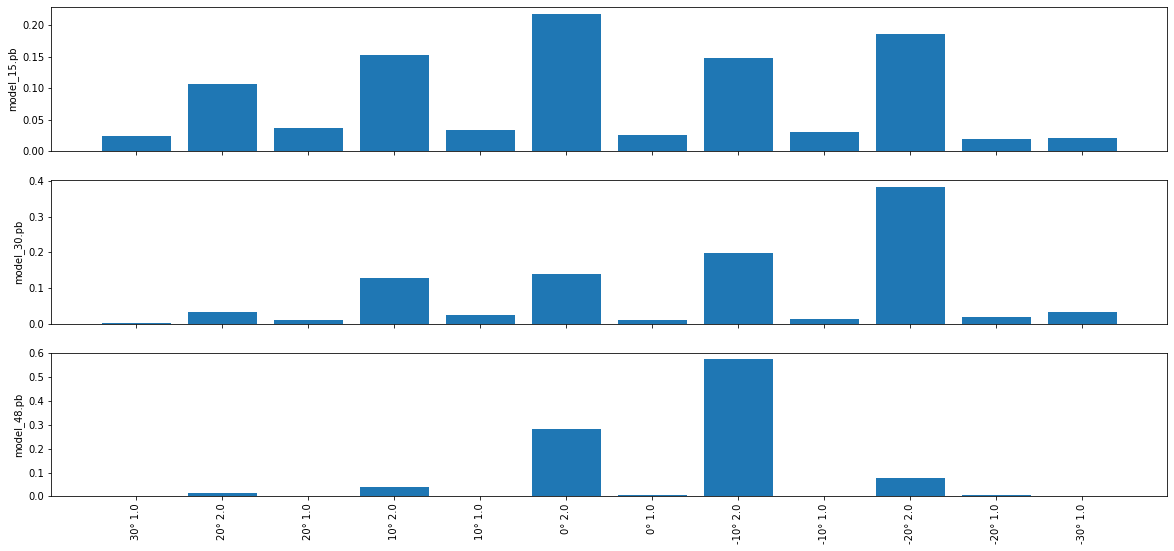

In [95]:
x = list(range(1,len(action_names)+1))

num_plots = len(iterations)
fig, ax = plt.subplots(num_plots,1,figsize=(20,3*num_plots),sharex=True,squeeze=False)

for p in range(0, num_plots):
    ax[p][0].bar(x,model_inference[p][PICTURE_INDEX][::-1])
    plt.setp(ax[p, 0], ylabel=os.path.basename(models_file_path[p]))
    
plt.xticks(x,action_names[::-1],rotation='vertical')
plt.show()

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [67]:
heatmaps = []
view_models = models_file_path[1:3]

for model_file in view_models:
    model, obs, model_out = load_session(model_file, my_sensor)
    arr = []
    for f in picture_files:
        img = cv2.imread(f)
        img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
        heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(action_names))
        heatmaps.append(heatmap)    

    tf.reset_default_graph()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: model/Demo-Reinvent-1/model/model_30.pb
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: model/Demo-Reinvent-1/model/model_48.pb


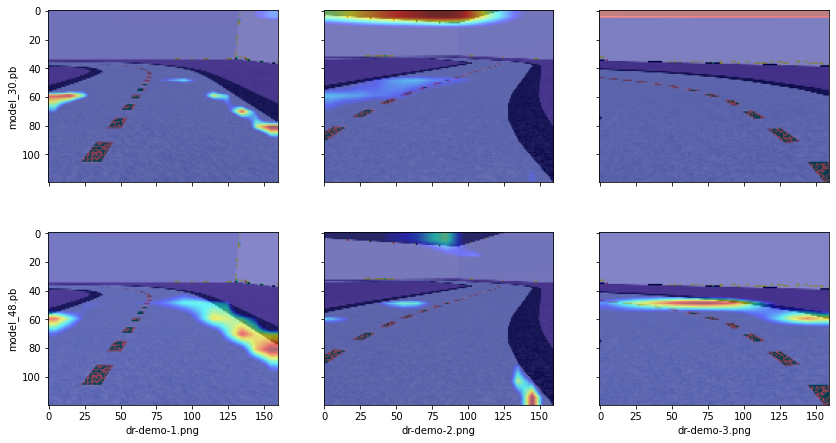

In [97]:
fig, ax = plt.subplots(len(view_models),len(picture_files),
                       figsize=(7*len(view_models),2.5*len(picture_files)), sharex=True, sharey=True, squeeze=False)

for i in list(range(len(view_models))):
    plt.setp(ax[i, 0], ylabel=os.path.basename(view_models[i]))
    for j in list(range(len(picture_files))):
        ax[i][j].imshow(heatmaps[i * len(picture_files) + j])
        plt.setp(ax[-1:, j], xlabel=os.path.basename(picture_files[j]))
       
plt.show()